In [31]:
#!conda info

In [32]:
import re
import numpy as np
import pandas as pd
#from nltk.tokenize import word_tokenize
#from nltk.stem import WordNetLemmatizer

from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

In [34]:
msg_df = pd.read_csv('/data2/home/prasannaiyer/Projects/NLP_Project/Data/disaster_messages.csv')

In [35]:
category_df = pd.read_csv('/home/prasannaiyer/Projects/NLP_Project/Data/disaster_categories.csv')

In [36]:
consol_df = msg_df.merge(category_df, left_on = 'id', right_on = 'id')

### Question 1: What is the count of messages by genre?

In [37]:
msg_genre = pd.Series(data = msg_df['genre'].value_counts().values/msg_df['genre'].value_counts().sum(), \
    index = msg_df['genre'].value_counts().index)
msg_genre = (msg_genre*100).round(0).astype(int)

[Text(0, 0, '13068'), Text(0, 0, '10782'), Text(0, 0, '2398')]

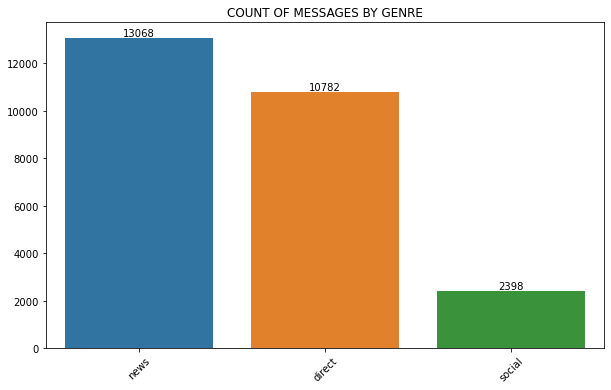

In [38]:
plt.figure(figsize = (10, 6))
ax = sns.barplot(x = msg_df['genre'].value_counts().index, y = msg_df['genre'].value_counts().values)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)
ax.set_title('COUNT OF MESSAGES BY GENRE')
ax.bar_label(ax.containers[0])



### Question 2: Are there any null values in the message dataset?

In [39]:
categories = consol_df['categories'].str.split(pat = ';', expand = True)

In [40]:
cat_names = categories[0:1].apply(lambda x: x.str[:-2]).astype(str)

In [41]:
categories.columns = cat_names.values.flatten().tolist()

In [42]:
for column in categories.columns:
    categories[column] = categories[column].str[-1]

In [43]:
msg_cat_df = pd.concat([consol_df, categories], axis = 1)

In [44]:
msg_cat_df.drop(columns = ['categories'], axis = 1, inplace = True)

In [45]:
msg_cat_clean_df = msg_cat_df.drop_duplicates()

In [46]:
msg_cat_df[msg_cat_df.duplicated()].shape

(170, 40)

In [47]:
msg_cat_clean_df[msg_cat_clean_df.duplicated()].shape

(0, 40)